# Generate synthetic networks for null model

In [109]:
import math

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_theme(style='darkgrid')

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf

In [191]:
# Define functions
def get_at(tpoint, G) :
    """
    Get network snapshot at specific timepoint.
    """
    return [(u,v) for (u,v,e) in G.edges(data=True) if tpoint in e['t']]

def get_between(start, end, G) :
    """
    Get network snapshot aggregated between two timepoints.
    """
    in_test = lambda u,v : any([start <= t < end for t in G[u][v]['t']])    # Loses information for multiple edges
    return nx.subgraph_view(G, filter_edge=in_test)

def get_networks(start, end, size, G) :
    """
    Returns network snapshots as aggreagated *subgraphs* of network G between tpoints 'start' and 'end'.
    """
    points = list(range(start, end, size))
    chunks = zip(points, points[1:] + [end])     # Will fail if tend is a multiple of tsize
    return [get_between(*chunk, G) for chunk in chunks]

def plot_corr(corrmat, props=None, vmin=-1, vmax=1) :
    """
    Plot correlation matrix (simply a utility function).
    """
    plt.imshow(corrmat, cmap=mpl.cm.coolwarm, vmin=vmin, vmax=vmax)
    plt.gca().grid(False)
    plt.colorbar()

    if props :
        plt.gca().set_xticks(range(len(props)))
        plt.gca().set_xticklabels(list(props.keys()), rotation=60)
        plt.gca().set_yticks(range(len(props)))
        plt.gca().set_yticklabels(list(props.keys()), rotation=0)
        
def draw_periodic(data, return_data=False, title="data", axs=None) :
    """
    Plot time series, autocorrelation function, and power spectrum of "data".
    """
    if axs is None :
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    ### Plot time series
    axs[0].plot(data)
    axs[0].set_ylabel(title, fontsize='x-large')

    ### Plot ACF
    axs[1].set_ylabel('$ACF(\\tau)$')
    acf, acf_conf = smt.acf(data, nlags=len(data)-1, alpha=0.05)
    axs[1].plot(acf)
    axs[1].fill_between(np.arange(0, len(data)), acf_conf[:, 0] - acf, acf_conf[:, 1] - acf, alpha=0.25)

    # Plot power spectrum
    axs[2].set_ylabel('$S(f)$')
    fourier_transform = np.fft.rfft(acf)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    axs[2].plot(power_spectrum[1:])
    # axs[2].plot(np.linspace(0, 1/20, len(power_spectrum))[1:], power_spectrum[1:])

    plt.tight_layout()

    if return_data : return (acf, acf_conf), power_spectrum

def get_props(Gs) :
    """
    Get time series for the full range of properties for a sequence of network snapshots.
    """
    n = Gs[0].number_of_nodes()

    # Connected components
    ccs = [sorted([c for c in nx.connected_components(G) if len(c) > 1], key=len, reverse=True) for G in Gs]
    # Size of connected components
    ccs_size = [[len(c) for c in cc] for cc in ccs]

    # Number of active nodes
    n_a = [sum(cc) for cc in ccs_size]
    # Number of active edges
    m_a = [G.number_of_edges() for G in Gs]
    # AVerage degree
    k_avg = [2 * m / n for m in m_a]
    # Max degree
    k_max = [max([len(list(nx.neighbors(G, n))) for n in G]) for G in Gs]
    # Average shortest path length (GCC)
    l = [nx.average_shortest_path_length(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Average density (full network)
    delta = [nx.density(G) for G in Gs]
    # Average density (active)
    delta_a = 2 * np.array(m_a) / (np.array(n_a)**2 - n_a)
    # Average WS clustering (full network)
    clustering = [nx.average_clustering(G) for G in Gs]
    # Average WS clustering (active)
    clustering_a = [nx.average_clustering(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Transitivity (full network)
    transitivity = [nx.transitivity(G) for G in Gs]
    # Transitivity (active)
    transitivity_a = [nx.transitivity(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Number of connected components
    n_c = [len(cc) for cc in ccs]
    # Average size of connected components
    s = [np.mean(cc) if cc else 0 for cc in ccs_size]
    # Size of GCC
    s_max = [max(cc) if cc else 0 for cc in ccs_size]
    
    ### Return properties dict
    props = {
        '$n_a$': n_a,
        '$m_a$': m_a,
        '$\langle k \\rangle$': k_avg,
        '$k_{max}$': k_max,
        '$l$': l,
        '$\delta$': delta,
        # '$\delta_a$': delta_a,
        '$\\bar{C}$': clustering,
        '$\\bar{C}_a$': clustering_a,
        '$C$': transitivity,
        '$C_a$': transitivity_a,
        '$n_c$': n_c,
        '$S$': s,
        '$S_{max}$': s_max,
    }

    return props

def draw_full_range(Gs, props=None) :
    """
    Plot time series, autocorrelation, and power spectrum for the full range of properties. Used to generate plots in report
    """
    if props is None :
        props = get_props(Gs)

    fig, axs = plt.subplots(len(props), 3, figsize=(10, len(props)*1.5))

    props_items = list(props.items())
    for i, ax3 in enumerate(axs) :
        draw_periodic(props_items[i][1], title=props_items[i][0], axs=ax3)

    axs[-1][0].set_xlabel('$t$')
    axs[-1][1].set_xlabel('$\\tau$')
    axs[-1][2].set_xlabel('$f$')

    plt.tight_layout()
    plt.savefig('full_plot.png', dpi=300)

    return props

## White networks — q=1

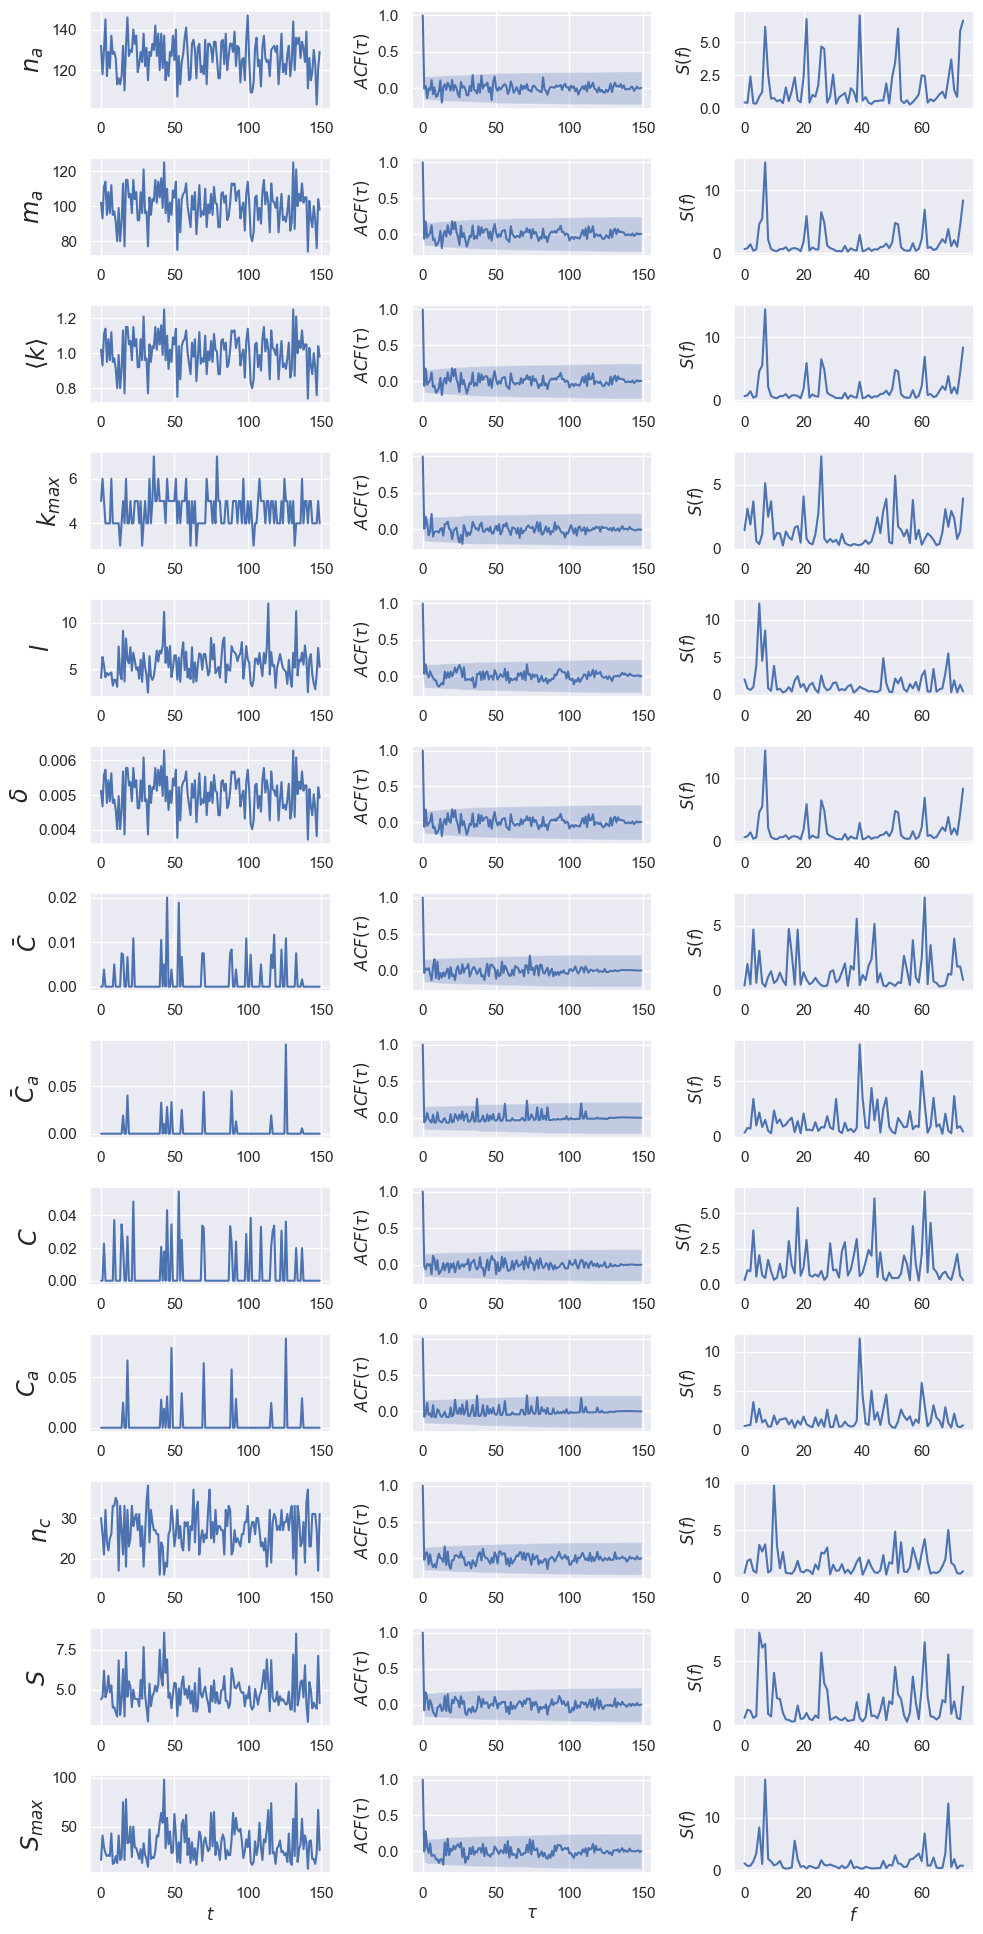

In [209]:
T = 30              # Period
concats = 5         # Repetitions
N = T * concats     # Total length of snapshot sequence

n = 200         # Total number of nodes
p = 0.005       # Connection probability
q = 1           # Noise level — q=1 fully uncorrelated

# Generate initial sequence
ERs = []
for i in range(T) :
    ERs.append(nx.erdos_renyi_graph(n, p))

# Generate new noisy sequences and concatenate
ERs_new = []
for i in range(concats) :
    ERs_copy = [G.copy() for G in ERs]  # Shallow copy, but sufficient here
    for G in ERs_copy :     # This could easily be optimized
        for u in G :
            for v in range(u+1, len(G)):
                if np.random.binomial(1, q) :
                    if np.random.binomial(1, p) :
                        if not G.has_edge(u, v) :
                            G.add_edge(u, v)
                    else :
                        if G.has_edge(u, v) :
                            G.remove_edge(u, v)
    ERs_new += ERs_copy
ERs = ERs_new

# Plot properties
props_p1 = draw_full_range(ERs)

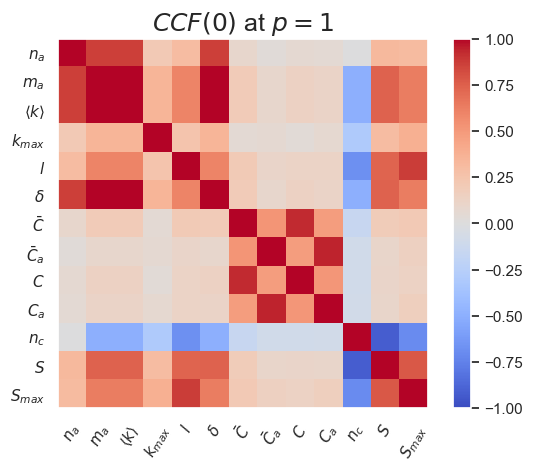

In [218]:
# Calculate and plot correlation matrix of properties
corrmat = np.corrcoef(np.array(list(props_p1.values())))

plot_corr(corrmat, props=props_p1)
plt.title("$CCF(0)$ at $p=1$", fontsize=18)
plt.savefig('null_p1_corr.png', dpi=300)

## Noisy periodic networks — p < 1

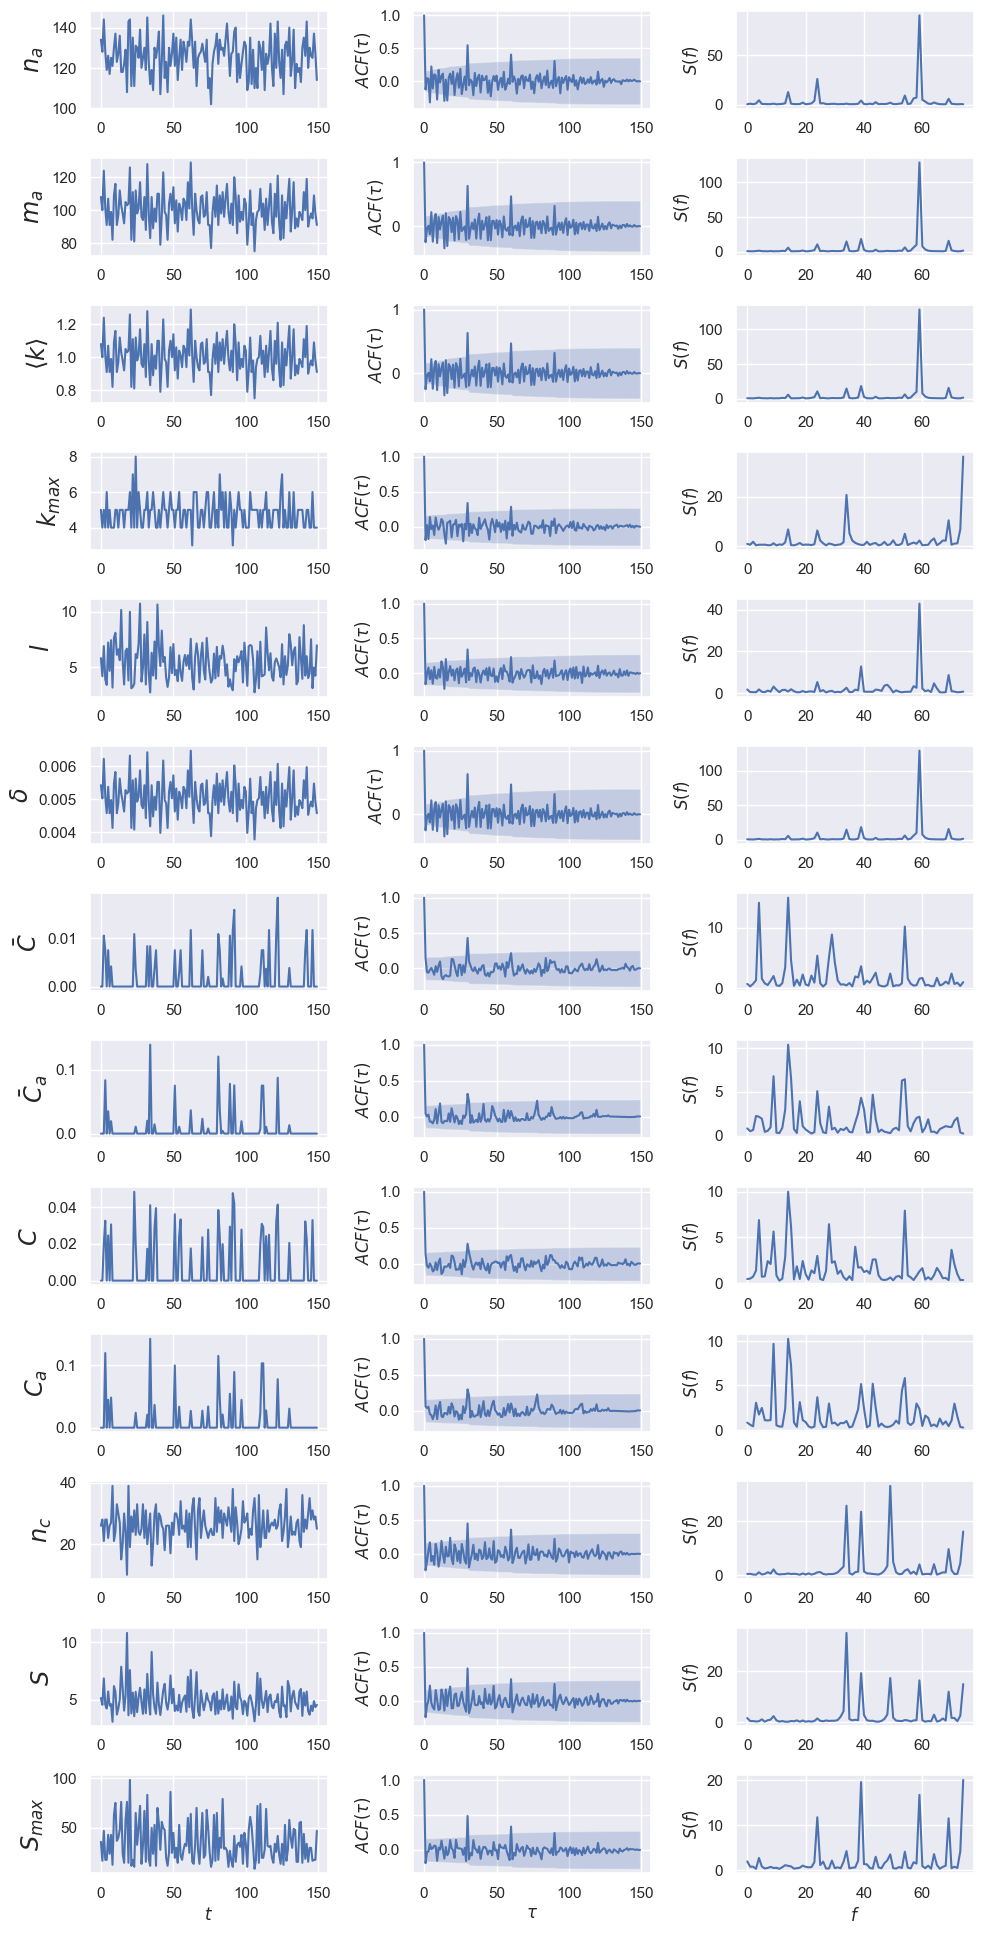

In [212]:
T = 30              # Period
concats = 5         # Repetitions
N = T * concats     # Total length of snapshot sequence

n = 200         # Total number of nodes
p = 0.005       # Connection probability
q = 0.15        # Noise level

# Generate initial sequence
ERs = []
for i in range(T) :
    ERs.append(nx.erdos_renyi_graph(n, p))

# Generate new noisy sequences and concatenate
ERs_new = []
for i in range(concats) :
    ERs_copy = [G.copy() for G in ERs]  # Shallow copy, but sufficient here
    for G in ERs_copy :     # This could easily be optimized
        for u in G :
            for v in range(u+1, len(G)):
                if np.random.binomial(1, q) :
                    if np.random.binomial(1, p) :
                        if not G.has_edge(u, v) :
                            G.add_edge(u, v)
                    else :
                        if G.has_edge(u, v) :
                            G.remove_edge(u, v)
    ERs_new += ERs_copy
ERs = ERs_new

# Plot properties
props_p015 = draw_full_range(ERs)

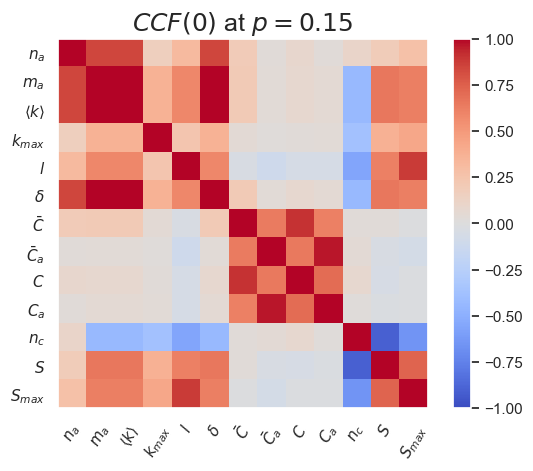

In [219]:
# Calculate and plot correlation matrix
corrmat = np.corrcoef(np.array(list(props_p015.values())))

plot_corr(corrmat, props_p015)
plt.title("$CCF(0)$ at $p=0.15$", fontsize=18)
plt.savefig('null_p015_corr.png', dpi=300)

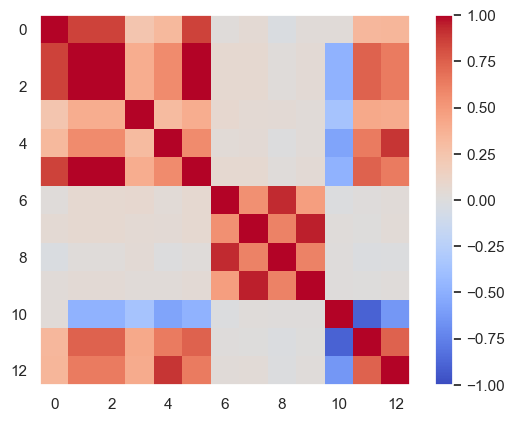

In [205]:
# Define helper function and extract correlation matrix averaged over M realizations
def gen_null_corr() :
    T = 30
    concats = 3
    N = T * concats

    n = 200
    p = 0.005
    q = 0.15

    ERs = []
    for i in range(T) :
        ERs.append(nx.erdos_renyi_graph(n, p))

    ERs_new = []
    for i in range(concats) :
        ERs_copy = [G.copy() for G in ERs]  # Shallow copy, but sufficient here
        for G in ERs_copy :     # This could easily be optimized
            for u in G :
                for v in range(u+1, len(G)):
                    if np.random.binomial(1, q) :
                        if np.random.binomial(1, p) :
                            if not G.has_edge(u, v) :
                                G.add_edge(u, v)
                        else :
                            if G.has_edge(u, v) :
                                G.remove_edge(u, v)
        
        ERs_new += ERs_copy

    ERs = ERs_new

    props = get_props(ERs)
    corrmat = np.corrcoef(np.array(list(props.values())))

    return corrmat

M = 10

corr_m1 = gen_null_corr()
corr_m2 = gen_null_corr() ** 2
for i in range(1, M) :
    corr = gen_null_corr()
    corr_m1 += corr
    corr_m2 += corr ** 2

corr_m1 /= M
corr_m2 /= M

plot_corr(corr_m1)

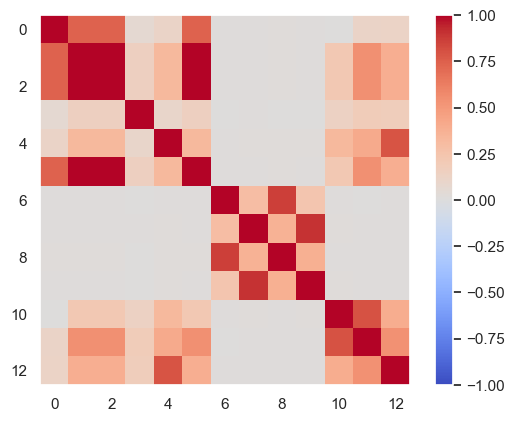

In [207]:
plot_corr(corr_m2)

In [208]:
np.savetxt('null_corr_m1.txt', corr_m1)
np.savetxt('null_corr_m2.txt', corr_m2)

## Perfectly periodic networks — q=0

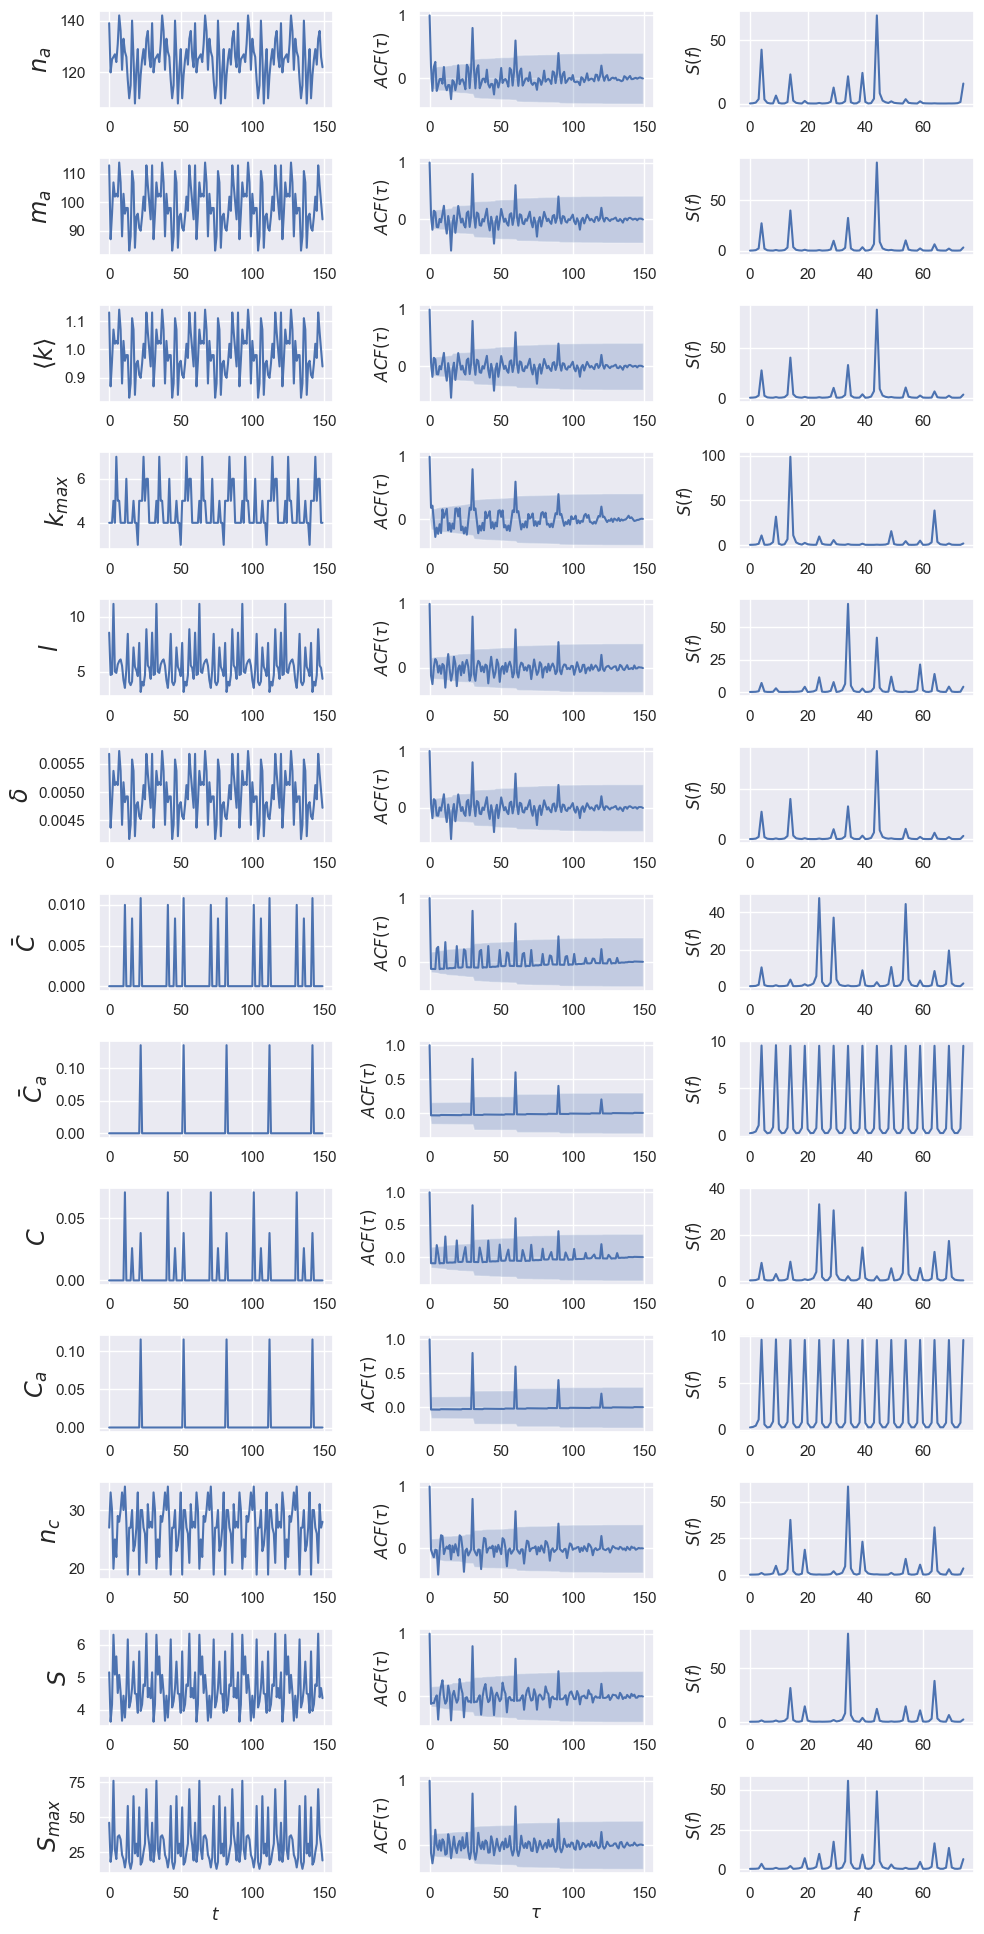

In [222]:
T = 30              # Period
concats = 5         # Repetitions
N = T * concats     # Total length of snapshot sequence

n = 200         # Total number of nodes
p = 0.005       # Connection probability
q = 0           # Noise level — q=0 perfectly periodic

# Generate initial sequence
ERs = []
for i in range(T) :
    ERs.append(nx.erdos_renyi_graph(n, p))

ERs_new = []
for i in range(concats) :
    ERs_copy = [G.copy() for G in ERs]  # Shallow copy, but sufficient here
    for G in ERs_copy :     # This could easily be optimized
        for u in G :
            for v in range(u+1, len(G)):
                if np.random.binomial(1, q) :
                    if np.random.binomial(1, p) :
                        if not G.has_edge(u, v) :
                            G.add_edge(u, v)
                    else :
                        if G.has_edge(u, v) :
                            G.remove_edge(u, v)
    ERs_new += ERs_copy
ERs = ERs_new

# Plot properties
props_p0 = draw_full_range(ERs)

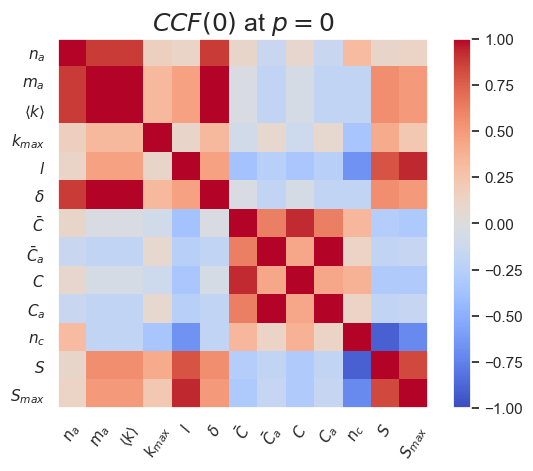

In [223]:
# Calcualte and plot correlation matrix
corrmat = np.corrcoef(np.array(list(props_p0.values())))

plot_corr(corrmat, props_p0)
plt.title("$CCF(0)$ at $p=0$", fontsize=18)
plt.savefig('null_p0_corr.png', dpi=300)